In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import scipy.linalg
import scipy.signal

from rfest import get_stimulus_design_matrix
from rfest import ARD, ASD, ALD, splineLG

from sklearn.metrics import r2_score

The following script to simulate correlated noise data is ported from matlab code by [leaduncker](https://github.com/leaduncker/SimpleEvidenceOpt).

# Make 2D Receptive Field

In [2]:
dt = 1/60 # time bin size
nt = 30
nx = 40
tt = np.arange(-nt*dt, 0, dt)

kt1 = scipy.stats.gamma.pdf(-tt, 4, scale=.025)
kt2 = scipy.stats.gamma.pdf(-tt, 6, scale=.03)
kt1 /= np.linalg.norm(kt1)
kt2 /= -np.linalg.norm(kt2)

kt = np.vstack([kt1, kt2]).T

xx = np.linspace(-2, 2, nx)

kx1 = np.cos(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)
kx2 = np.sin(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)

kx1 /= np.linalg.norm(kx1)
kx2 /= np.linalg.norm(kx2)

kx = np.vstack([kx1, kx2])

k = kt @ kx
k_norm = k/np.linalg.norm(k)

Text(0.5, 1.0, 'True Receptive Field')

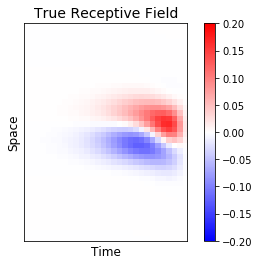

In [3]:
plt.imshow(k_norm.T, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Time', fontsize=12)
plt.ylabel('Space', fontsize=12)
plt.title('True Receptive Field', fontsize=14)

# Simulate Correlated Noise and Response

In [4]:
N = 5000 # sample size
signse = 1 # noise stdev
Sigma = scipy.linalg.toeplitz(np.exp(-(np.arange(0, nx)) / (nx/6))) # correlated (AR1) stim covariance

mu = np.zeros(nx)
np.random.seed(2046)
Stim = np.random.multivariate_normal(mu, Sigma, N) 
X = get_stimulus_design_matrix(Stim, nt)
y = X @ k.flatten() + signse * np.random.randn(N)

dims = [nt, nx] # Receptive fields dims

# Run ASD, ALD, splineLG

In [5]:
asd = ASD(X, y, dims, compute_mle=False)
asd.fit(initial_params=np.array([1. , 1., 7., 7.,]), num_iters=10)

Iter	σ	ρ	δt	δs	cost


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


   0	1.010	1.010	7.010	7.010	17729.151
   1	1.020	1.017	7.017	7.019	17473.193
   2	1.030	1.021	7.020	7.026	17258.328
   3	1.040	1.024	7.024	7.034	17047.018
   4	1.050	1.021	7.027	7.040	16815.947
   5	1.060	1.020	7.032	7.047	16600.282
   6	1.070	1.021	7.038	7.054	16431.481
   7	1.079	1.022	7.045	7.062	16259.855
   8	1.089	1.022	7.049	7.068	16034.402
   9	1.099	1.022	7.053	7.076	15877.114
Stop: reached 10 steps, final cost=15877.11405726599.


In [6]:
ald = ALD(X, y, dims, compute_mle=False)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
init_params = sigma0 + rho0 + params_t0 + params_y0
ald.fit(initial_params=init_params, num_iters=10)

Iter	σ	ρ	τs_t	τf_t	τs_y	τf_y	cost
   0	1.010	1.010	3.010	1.010	3.010	1.010	9070.095
   1	1.020	1.014	3.016	1.016	3.013	1.020	8815.250
   2	1.030	1.016	3.021	1.024	3.014	1.029	8569.341
   3	1.040	1.017	3.022	1.033	3.014	1.038	8315.338
   4	1.050	1.018	3.022	1.042	3.013	1.047	8066.947
   5	1.060	1.020	3.023	1.051	3.010	1.056	7830.308
   6	1.070	1.017	3.019	1.060	3.009	1.063	7596.865
   7	1.079	1.015	3.014	1.069	3.006	1.069	7364.663
   8	1.089	1.013	3.011	1.078	3.004	1.075	7151.431
   9	1.099	1.011	3.007	1.087	3.002	1.081	6941.629
Stop: reached 10 steps, final cost=6941.629400116438.


In [7]:
spl = splineLG(X, y, dims=dims, df_splines=14, compute_mle=True)
spl.fit(num_iters=500, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	4.753	
100	1.242	
200	1.242	
300	1.243	
400	1.245	
Stop: reached 500 steps, final cost=1.2461593323474043.


# Plot Results

Text(0, 0.5, 'Space')

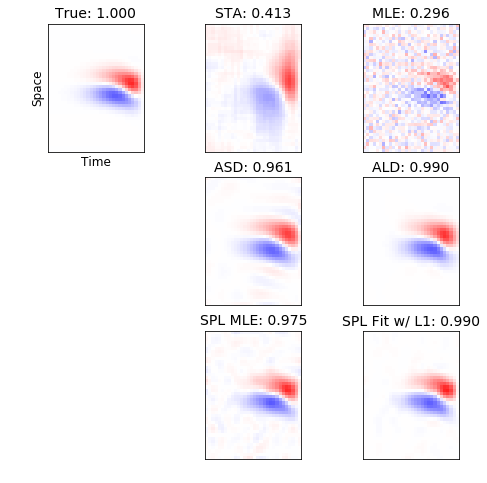

In [8]:
fig, ax = plt.subplots(3,3, figsize=(8, 8))
ax = ax.flatten()
labels = ['True', 'STA', 'MLE', '', 'ASD', 'ALD', '', 'SPL MLE', 'SPL Fit w/ L1']
for ii, w in enumerate([k, spl.w_sta, spl.w_mle, 0, asd.w_opt, ald.w_opt , 0, spl.w_spl, spl.w_opt]):
    
    if np.ndim(w) == 0:
        ax[ii].axis('off')
        continue
    
    w = w.reshape(dims) 
    w_norm =  w /np.linalg.norm(w)
    ax[ii].imshow(w_norm.T, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[ii].set_title("{0}: {1:.3f}".format(labels[ii], r2_score(k_norm.flatten(), w_norm.flatten())), fontsize=14)
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Space', fontsize=12)

Numbers indicate the r2 score of the true RF and the retrieved RF.